### **Install packages** 

In [ ]:
install.packages("keras")
install.packages("ISLR2")
install.packages("dplyr")

In [ ]:
library(keras)
library(tensorflow)
library(ISLR2)
library(dplyr)

### **Load midterm data:**

In [3]:
Data <- read.csv('/content/ReformattedLastTermDataWithTimeFeatures.csv')

### **Perform some data processing:**

In [4]:
Data <- select(Data,-c("Major2","CompleteCIP1","HSDipYr",
  "HSGPAUnwtd","NumColCredAttemptTransfer","Adjusted.Gross.Income",
  "Parent.Adjusted.Gross.Income","BirthYear","BirthMonth","Birth_date", "StudentID"))

In [5]:
# convert some variables to factor (from character)
 vars = c("Marital.Status","FathersEducation","MothersEducation","Housing","Ethnicity",
        "EnrollmentStability", "Major1")
 Data[vars] <- lapply(Data[vars], factor)  ## as.factor() could also be used

Data$NumColCredAcceptTransfer[Data$NumColCredAcceptTransfer<0] = 0
Data$Age[is.na(Data$Age)] = mean(Data$Age,na.rm=T)

In [6]:
# Remove leakage vars
Data <- select(Data, -c("Complete1","NumTermsEnrolled","TimeEnrolled","TotalDebt",
                "TotalGrants","TotalScholarships","TotalWorkStudy",
                "RealNA","AcademicYear","Cohort","RegistrationDate",
                "X2012.Loan","X2012.Scholarship","X2012.Work.Study","X2012.Grant","X2013.Loan","X2013.Scholarship",
                "X2013.Work.Study","X2013.Grant","X2014.Loan","X2014.Scholarship","X2014.Work.Study","X2014.Grant",
                "X2015.Loan","X2015.Scholarship","X2015.Work.Study","X2015.Grant","X2016.Loan","X2016.Scholarship",
                "X2016.Work.Study","X2016.Grant","X2017.Loan","X2017.Scholarship","X2017.Work.Study","X2017.Grant"))

### **Split data into train and test:**

In [7]:
# Test and train set
test.dat <- filter(Data, is.na(Dropout))
train.dat <- filter(Data, !is.na(Dropout))

In [ ]:
# split into input (X) and output (Y) variables
x_inputs <- select(train.dat, -c("Dropout"))
x_train <- scale(model.matrix(~.-1, data = x_inputs))
y_output <- train.dat$Dropout
y_train <- to_categorical(y_output, num_classes = 2)
x_test_dat <- select(test.dat, -c("Dropout"))
x_test <- scale(model.matrix(~.-1, data = x_test_dat)) 

### **Model 1**

In [50]:
#Build the model
nn <- keras_model_sequential () %>%
#input layer
layer_dense(units = 100, activation = "sigmoid",input_shape = ncol(x_train)) %>%
layer_dropout(rate = 0.6) %>%
#hidden layer
layer_dense(units = 50, activation = "sigmoid") %>%
layer_dropout(rate = 0.5) %>%
#output layer
layer_dense(units = ncol(y_train), activation = "softmax")

In [ ]:
summary(nn)

In [51]:
#Compile the model
nn %>% compile(loss = "categorical_crossentropy", optimizer = optimizer_sgd(learning_rate=0.2, decay=1e-6, momentum=0.9), metrics = "accuracy")

In [52]:
set.seed(24)
history <-  fit(nn,  x_train, y_train, epochs = 100, batch_size = 64, validation_split = 0.2)

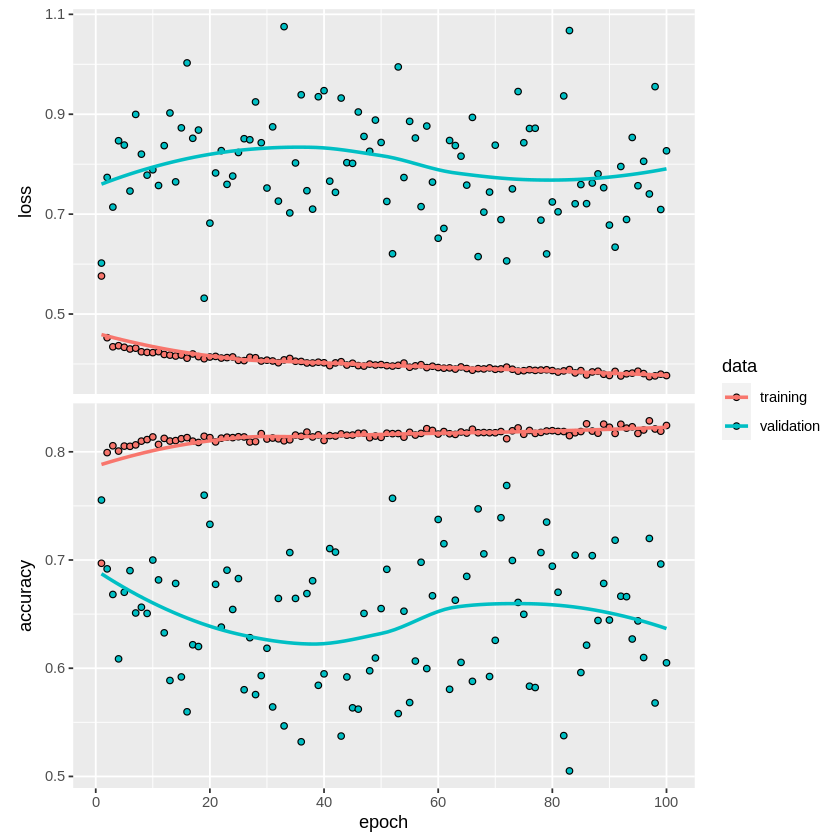

In [53]:
plot(history)

Predict on test set:

In [54]:
npred <- nn %>% predict(x_test)

### **Model 2**

In [55]:
#Build the model
nn2 <- keras_model_sequential() %>%
  #input layer
  layer_dense(units = 100, input_shape = ncol(x_train), kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(100))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer one
  layer_dense(units = 50, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(50))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer two
  layer_dense(units = 25, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(25))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer three
  layer_dense(units = 10, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(10))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #output layer 
  layer_dense(units = ncol(y_train), kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(ncol(y_train)))) %>%
  layer_activation("softmax")

In [ ]:
summary(nn2)

In [56]:
# Compile the model
nn2 %>% compile(loss = "categorical_crossentropy", optimizer = optimizer_sgd(learning_rate=0.2, decay=1e-6, momentum=0.9, nesterov=TRUE), metrics = "accuracy")

In [57]:
set.seed(24)
history2 <- fit(nn2, x_train, y_train, epochs = 100, batch_size = 64, validation_split = 0.2)

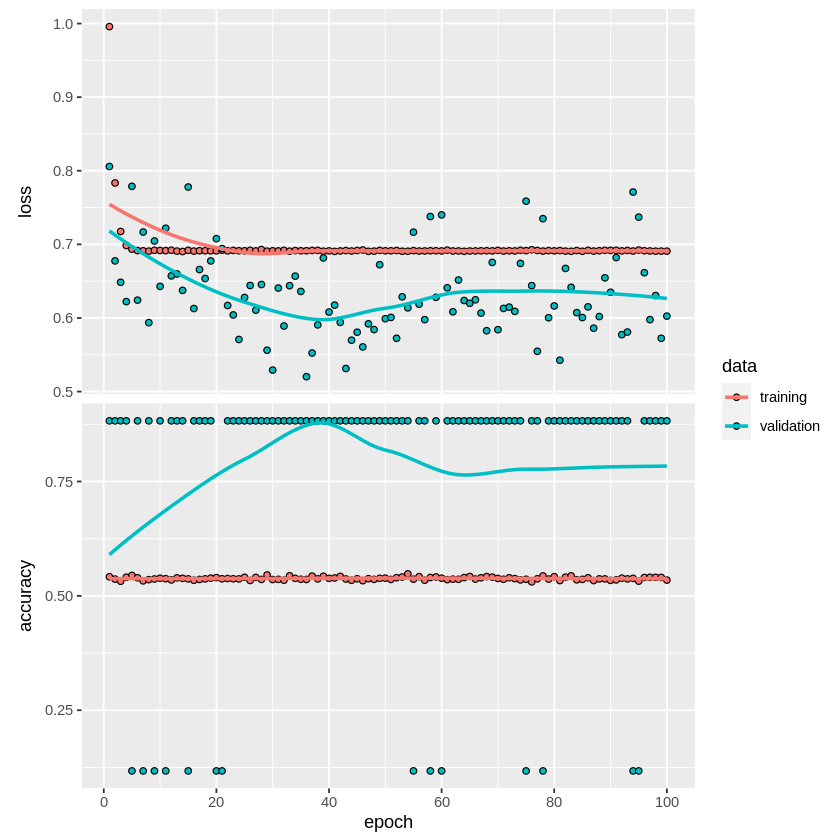

In [58]:
plot(history2)

Predict on test set:

In [59]:
npred2 <- nn2 %>% predict(x_test)

### **Model 3**

I noticed with the earlier models that there might be some overfitting. So for this last model, I decided to experiment with early stopping in order to prevent overfitting and to improve the generalization performance of the model. Early stopping can help prevent overfitting by monitoring the performance of the model on the validation set during training and stopping the training process when the performance on the validation set has not improved for a certain number of epochs. 

In terms of tuning the learning rate, I tried to implement a learning rate schedule, however the functions ReduceLROnPlateau() and LearningRateScheduler() were not working. So, I played around with different learning rate values and settled on a value of 0.2 as it yielded the best performance in terms of val_accuracy.

In [60]:
#Build the model
nn3 <- keras_model_sequential () %>%
#input layer
layer_dense(units = 100, activation = "relu", input_shape = ncol(x_train), kernel_regularizer = regularizer_l2(l=0.001)) %>%
layer_dropout(rate = 0.5) %>%
#hidden layer one
layer_dense(units = 50, activation = "relu", kernel_regularizer = regularizer_l2(l=0.001)) %>%
layer_dropout(rate = 0.5) %>%
#hidden layer two
layer_dense(units = 25, activation = "relu", kernel_regularizer = regularizer_l2(l=0.001)) %>%
layer_dropout(rate = 0.5) %>%
#output layer
layer_dense(units = ncol(y_train), activation = "softmax")

In [61]:
#compile the model
nn3 %>% compile(loss = "categorical_crossentropy", optimizer = optimizer_sgd(learning_rate=0.2, decay=1e-6, momentum=0.9), metrics = "accuracy")

In [ ]:
summary(nn3)

In [62]:
set.seed(24)
history3 <- fit(nn3, x_train, y_train, epochs = 100, batch_size = 64, validation_split = 0.2, callbacks = list(callback_early_stopping(monitor = "val_loss", patience = 5, restore_best_weights = TRUE)))

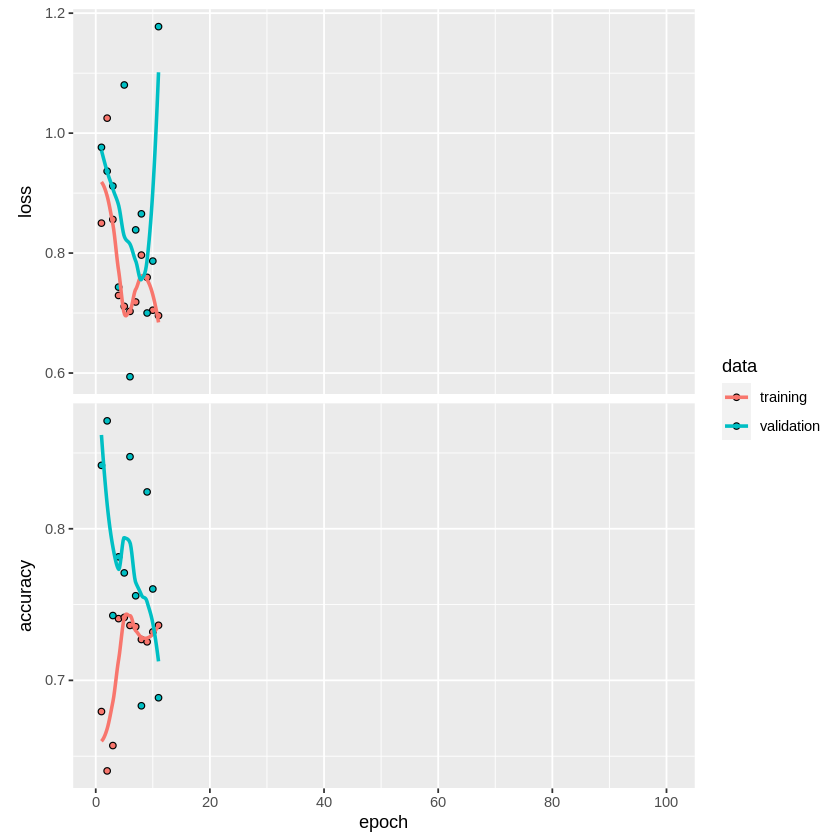

In [63]:
plot(history3)

Predict on test set:

In [64]:
npred3 <- nn3 %>% predict(x_test)

Another way I tried to curb overfitting was by reducing the input space in an effort to reduce model complexity. Thus, I ran the same three more neural network models as above, but this time only with the top 10 most important predictors of dropout as the x_inputs, which were identified during our midterm. 

### **Models (Round 2)**

In [65]:
# Create new dataset with only the top 10 most important predictors of dropout
Data2 <- select(Data, c("Dropout","CumGPA","Age","GPASlope","EnrollmentStability",
                      "TermGPA","Major1","EngPlacement","AvgGrantsPerTerm","AvgDebtPerTerm"))


In [66]:
# Test and train set
test.data <- filter(Data2, is.na(Dropout))
train.data <- filter(Data2, !is.na(Dropout))

In [67]:
# split into input (X) and output (Y) variables
inputs <- select(train.data, -c("Dropout"))
x_train_2 <- scale(model.matrix(~.-1, data = inputs))
y_output_2 <- train.data$Dropout
y_train_2 <- to_categorical(y_output_2, num_classes = 2)
x_test_data <- select(test.data, -c("Dropout"))
x_test_2 <- scale(model.matrix(~.-1, data = x_test_data))

Model 1.1

In [68]:
#Build the model
nn4 <- keras_model_sequential () %>%
#input layer
layer_dense(units = 100, activation = "sigmoid",input_shape = ncol(x_train_2)) %>%
layer_dropout(rate = 0.5) %>%
#hidden layer
layer_dense(units = 50, activation = "sigmoid") %>%
layer_dropout(rate = 0.5) %>%
#output layer
layer_dense(units = ncol(y_train_2), activation = "softmax")

In [69]:
#Compile the model
nn4 %>% compile(loss = "categorical_crossentropy", optimizer = optimizer_sgd(learning_rate=0.2, decay=1e-6, momentum=0.9), metrics = "accuracy")

In [70]:
set.seed(24)
history4 <-  fit(nn4,  x_train_2, y_train_2, epochs = 100, batch_size = 64, validation_split = 0.2)

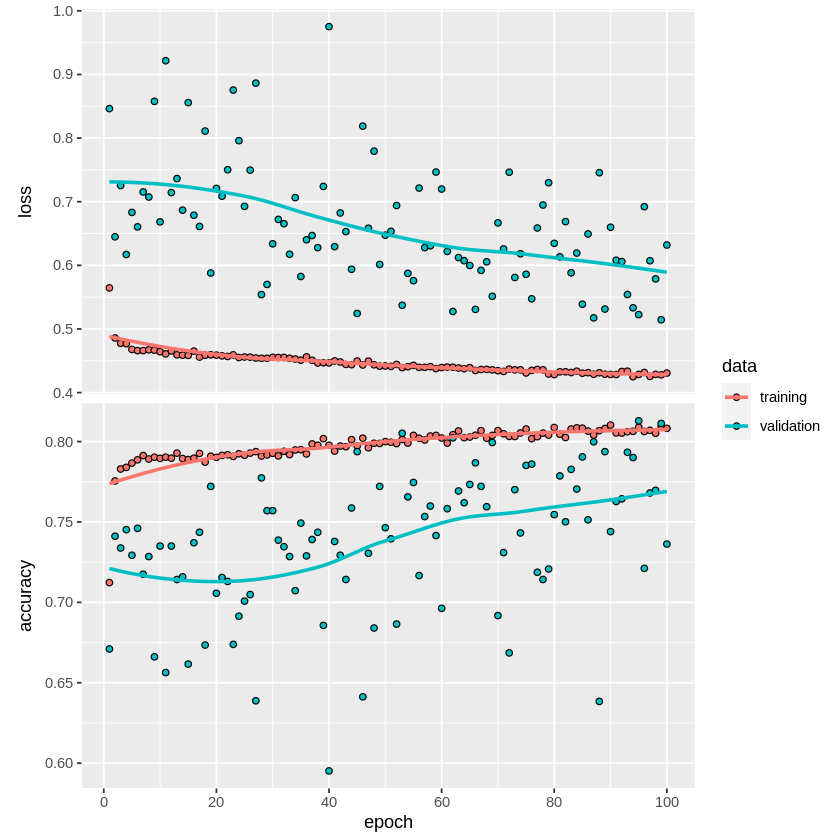

In [71]:
plot(history4)

Predict on test set:

In [72]:
npred4 <- nn4 %>% predict(x_test_2)

Model 2.1

In [73]:
#Build the model
nn5 <- keras_model_sequential() %>%
  #input layer
  layer_dense(units = 100, input_shape = ncol(x_train_2), kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(100))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer one
  layer_dense(units = 50, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(50))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer two
  layer_dense(units = 25, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(25))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #hidden layer three
  layer_dense(units = 10, kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(10))) %>%
  layer_activation("relu") %>%
  layer_dropout(rate = 0.5) %>%
  #output layer 
  layer_dense(units = ncol(y_train_2), kernel_regularizer = regularizer_l2(0.001), kernel_initializer = initializer_random_normal(mean = 0, stddev = 1/sqrt(2))) %>%
  layer_activation("softmax")

In [74]:
# Compile the model
nn5 %>% compile(loss = "categorical_crossentropy", optimizer = optimizer_sgd(learning_rate=0.2, decay=1e-6, momentum=0.9, nesterov=TRUE), metrics = "accuracy")

In [75]:
set.seed(24)
history5 <- fit(nn5, x_train_2, y_train_2, epochs = 100, batch_size = 64, validation_split = 0.2)

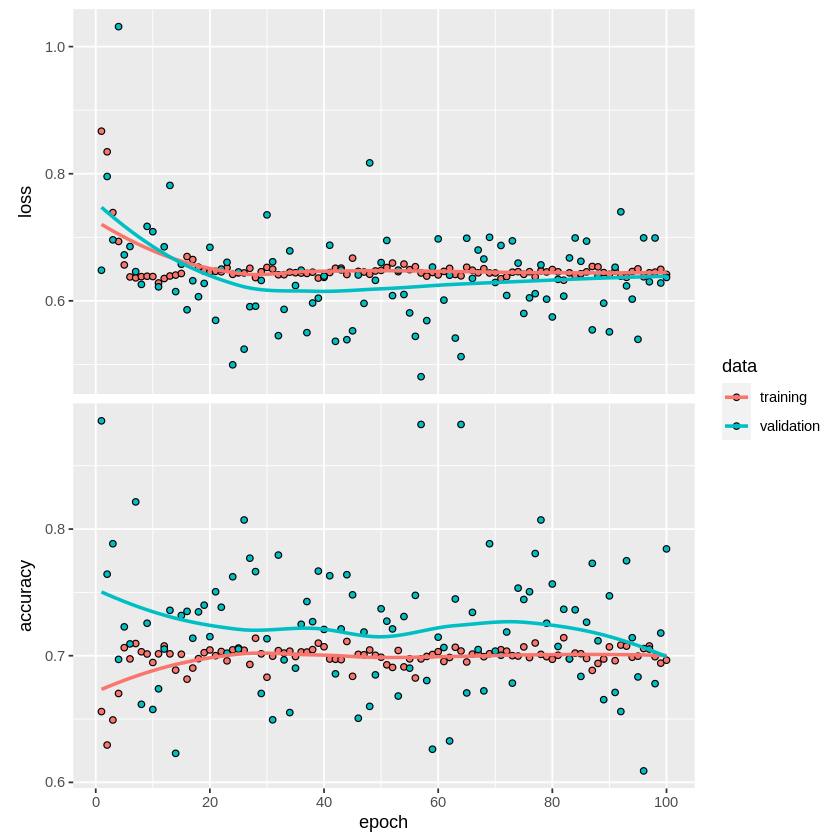

In [76]:
plot(history5)

Predict on test set:

In [77]:
npred5 <- nn5 %>% predict(x_test_2)

Model 3.1

In [78]:
#Build the model
nn6 <- keras_model_sequential () %>%
#input layer
layer_dense(units = 100, activation = "relu", input_shape = ncol(x_train_2), kernel_regularizer = regularizer_l2(l=0.001)) %>%
layer_dropout(rate = 0.5) %>%
#hidden layer one
layer_dense(units = 50, activation = "relu", kernel_regularizer = regularizer_l2(l=0.001)) %>%
layer_dropout(rate = 0.5) %>%
#hidden layer two
layer_dense(units = 25, activation = "relu", kernel_regularizer = regularizer_l2(l=0.001)) %>%
layer_dropout(rate = 0.5) %>%
#output layer
layer_dense(units = ncol(y_train_2), activation = "softmax")

In [79]:
#compile the model
nn6 %>% compile(loss = "categorical_crossentropy", optimizer = optimizer_sgd(learning_rate=0.2, decay=1e-6, momentum=0.9), metrics = "accuracy")

In [80]:
set.seed(24)
history6 <- fit(nn6, x_train_2, y_train_2, epochs = 100, batch_size = 64, validation_split = 0.2, callbacks = list(callback_early_stopping(monitor = "val_loss", patience = 5, restore_best_weights = TRUE)))

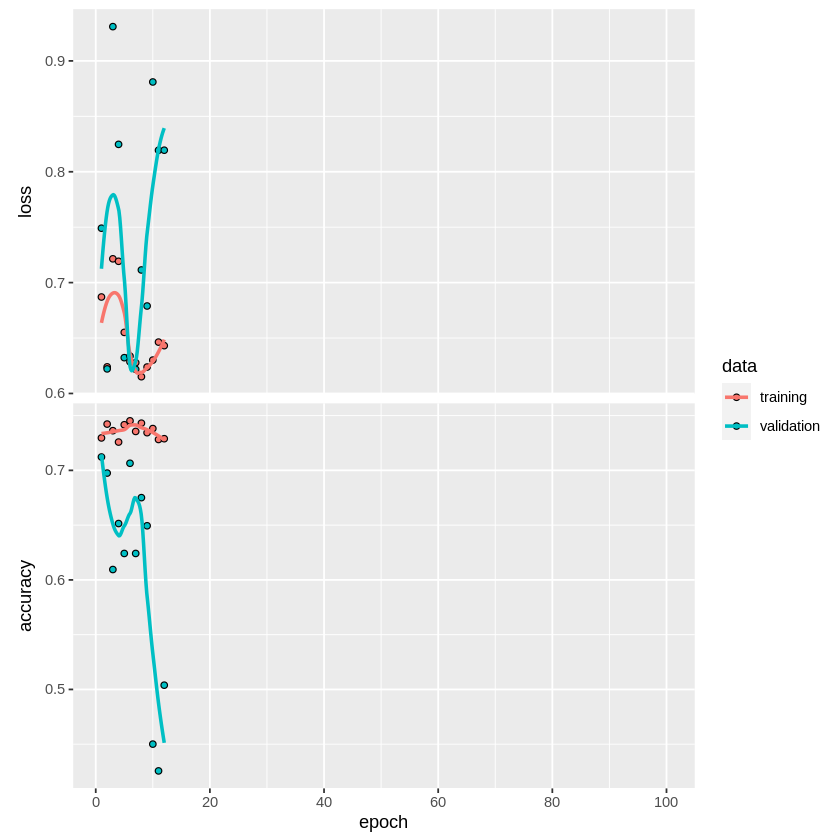

In [81]:
plot(history6)

Predict on test set:

In [82]:
npred6 <- nn6 %>% predict(x_test_2)

### **Model Summary**

In [95]:
#Obtaining the final epoch val_accuracy measures for each neural network 
accuracy_1 <- history$metrics$val_accuracy[100]

accuracy_2 <- history2$metrics$val_accuracy[100]

accuracy_3 <- history3$metrics$val_accuracy[11]

accuracy_4 <- history4$metrics$val_accuracy[100]

accuracy_5 <- history5$metrics$val_accuracy[100]

accuracy_6 <- history6$metrics$val_accuracy[12]

## Note: the above values for final epoch accuracy change with each subsequent run  
## on colab despite the set.seed(24). Thus, I used the validation accuracy values 
## from my first colab run for my answer to question 4 of the homework
## (i.e. the conclusion section below). 


In [101]:
#Combining neural network scores and midterm model scores in one dataframe
df <- data.frame("Model Name", "Accuracy", check.names = FALSE)
df[1,1] <- c("Neural Network 1")
df[2,1] <- c("Neural Network 2")
df[3,1] <- c("Neural Network 3")
df[4,1] <- c("Neural Network 1.1")
df[5,1] <- c("Neural Network 2.1")
df[6,1] <- c("Neural Network 3.1")
df[7,1] <- c("Logistic Regression")
df[8,1] <- c("Vanilla XGB Boost")
df[9,1] <- c("XGB Boost with Smote")

## Note: I reran our midterm models on a local train and test set 
## (without the leakage variables) using the same validation split (0.2)  
## as with the neural network models and obtained the respective  
## accuracy values. Thus, the values you see here in the dataframe are 
## not the F1 scores from kaggle, but rather the accuracy values
## obtained from the validation split.


#Best accuracy values for each model:
df[1,2] <- sprintf("%.4f", round(history$metrics$val_accuracy[100],4))
df[2,2] <- round(history2$metrics$val_accuracy[100],4)
df[3,2] <- round(history3$metrics$val_accuracy[11],4)
df[4,2] <- round(history4$metrics$val_accuracy[100],4)
df[5,2] <- round(history5$metrics$val_accuracy[100],4)
df[6,2] <- round(history6$metrics$val_accuracy[12],4)
df[7,2] <- 0.8123
df[8,2] <- 0.8609
df[9,2] <- 0.8507

print(df)

          "Model Name" "Accuracy"
1     Neural Network 1     0.6050
2     Neural Network 2     0.8826
3     Neural Network 3     0.6885
4   Neural Network 1.1     0.7362
5   Neural Network 2.1     0.7843
6   Neural Network 3.1     0.5039
7  Logistic Regression     0.8123
8    Vanilla XGB Boost     0.8609
9 XGB Boost with Smote     0.8507


### **Data frame with final accuracy values\:**

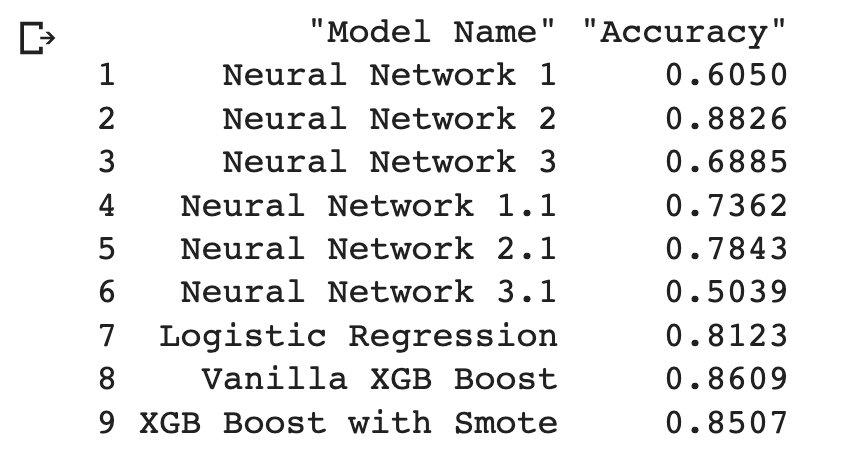

### **Conclusion:**

A softmax activation function was used in the last layer of all the neural networks because SoftMax takes a vector as the input. This vector has the same dimension as classes we have (2 classes in this case: 0 and 1). Because each input must belong to one class only *and* we want to output a vector where each component is a probability, we use the  SoftMax activation function. After applying SoftMax, each element will be in the range of 0 to 1, and SoftMax makes sure that the sum of all our output probabilities is equal to one. This way, our ouput can be interpreted as a probability distribution. Also, because we are primarily interested in the model's performance on the final test set, it is more appropriate to use the accuracy value from the final epoch. This will give us a better idea of how well the model is able to generalize to new data, and can provide a more realistic estimate of the model's performance on real-world tasks.

In terms of interpreting model accuracy, the second neural network performed the best with a final validation accuracy value of approximately 0.8826 (*note: this value was obtained in my first run of the code and may not appear again*). This model was better than all the models we ran for the midterm.

The first neural network model I ran with only one hidden layer was the worst performing model with an accuracy value of only 0.6050, followed by the third neural network model I ran with two hidden layes and an accuracy value of 0.6885. Both of these models were subpar compared to the logistic regression model and XGB boost models we ran for the midterm.

Finally, I ran the same neural network models again, but this time with only the top 10 most important predictors of dropout that were identified during our midterm. Within these models, again the second neural network model with three hidden layers was the best performing, with a final  accuracy value of 0.7843. But as you can see, it did not perform better than the initial neural network models I ran with all the input variables included.

***Note:*** *the final accuracy values for the neural network models mentioned here were obtained during my first run of the code and these same values may not appear again despite the set.seed(24).*